In [705]:

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import  StandardScaler, FunctionTransformer, OrdinalEncoder, OneHotEncoder, LabelEncoder,MinMaxScaler,power_transform
from sklearn.model_selection import train_test_split, RepeatedStratifiedKFold, cross_val_score,GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score,ConfusionMatrixDisplay
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import xgboost as xgb


In [706]:
df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')
ytest   =pd.read_csv('sample_submission.csv')

In [708]:
df = pd.merge(df_test,ytest,on='id')

In [709]:
df =  pd.concat([df_train, df], axis=0)  # axis=0 significa unir filas (verticalmente)


In [710]:
df

,id,day,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,2,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,3,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,4,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,5,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
725,2915,361,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,0
726,2916,362,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,0
727,2917,363,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,0
728,2918,364,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,0


In [711]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,2920.0,1459.500000,843.075718,0.0,729.75,1459.5,2189.25,2919.0
day,2920.0,180.711301,105.252537,1.0,89.75,180.0,271.00,365.0
pressure,2920.0,1013.577363,5.617592,999.0,1008.60,1013.0,1017.70,1034.6
maxtemp,2920.0,26.367466,5.657912,7.4,21.30,27.8,31.20,36.0
temparature,2920.0,23.955616,5.235483,5.9,19.40,25.5,28.40,31.8
mintemp,2920.0,22.155137,5.086431,4.0,17.70,23.9,26.40,29.8
dewpoint,2920.0,20.455959,5.313356,-0.3,16.80,22.2,25.00,26.7
humidity,2920.0,82.194863,7.808651,39.0,77.00,82.0,88.00,98.0
cloud,2920.0,75.881507,18.002503,0.0,69.00,83.0,88.00,100.0
sunshine,2920.0,3.724418,3.629109,0.0,0.40,2.4,6.80,12.1


In [712]:
df.drop(columns=['day'],inplace=True)
df_test.drop(columns=['day'],inplace=True)

In [713]:
df


,id,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall
0,0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1
1,1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1
2,2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1
3,3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1
4,4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0
...,...,...,...,...,...,...,...,...,...,...,...,...
725,2915,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,0
726,2916,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,0
727,2917,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,0
728,2918,1014.4,21.0,20.0,19.7,19.8,94.0,93.0,0.0,50.0,39.5,0


In [714]:
# Crear nuevas características basadas en datos existentes
df['temp_diff'] = df['maxtemp'] - df['mintemp']  # Diferencia entre temp máxima y mínima
df['humidity_ratio'] = df['humidity'] / (df['cloud'] + 1)  # Relación entre humedad y nubes
df['wind_power'] = df['windspeed'] * np.abs(np.cos(np.radians(df['winddirection'])))  # Potencia del viento



In [715]:
df_test['temp_diff'] = df_test['maxtemp'] - df_test['mintemp']  # Diferencia entre temp máxima y mínima
df_test['humidity_ratio'] = df_test['humidity'] / (df_test['cloud'] + 1)  # Relación entre humedad y nubes
df_test['wind_power'] = df_test['windspeed'] * np.abs(np.cos(np.radians(df_test['winddirection'])))

In [716]:
df.set_index('id',drop=True,inplace=True)
df

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,temp_diff,humidity_ratio,wind_power
id,,,,,,,,,,,,,,
0,1017.4,21.2,20.6,19.9,19.4,87.0,88.0,1.1,60.0,17.2,1,1.3,0.977528,8.600000
1,1019.5,16.2,16.9,15.8,15.4,95.0,91.0,0.0,50.0,21.9,1,0.4,1.032609,14.077049
2,1024.1,19.4,16.1,14.6,9.3,75.0,47.0,8.3,70.0,18.1,1,4.8,1.562500,6.190565
3,1013.4,18.1,17.8,16.9,16.8,95.0,95.0,0.0,60.0,35.6,1,1.2,0.989583,17.800000
4,1021.8,21.3,18.4,15.2,9.6,52.0,45.0,3.6,40.0,24.8,0,6.1,1.130435,18.997902
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,0,2.1,1.000000,32.231457
2916,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,0,7.2,0.962963,19.304320
2917,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,0,4.0,0.948454,14.077049


In [717]:
df.to_csv('dfcompeltpo.csv', index=False)

In [718]:
df_test.set_index('id',drop=True,inplace=True)
df_test

,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,temp_diff,humidity_ratio,wind_power
id,,,,,,,,,,,,,
2190,1019.5,17.5,15.8,12.7,14.9,96.0,99.0,0.0,50.0,24.3,4.8,0.960000,15.619739
2191,1016.5,17.5,16.5,15.8,15.1,97.0,99.0,0.0,50.0,35.3,1.7,0.970000,22.690403
2192,1023.9,11.2,10.4,9.4,8.9,86.0,96.0,0.0,40.0,16.9,1.8,0.886598,12.946151
2193,1022.9,20.6,17.3,15.2,9.5,75.0,45.0,7.1,20.0,50.6,5.4,1.630435,47.548447
2194,1022.2,16.1,13.8,6.4,4.3,68.0,49.0,9.2,20.0,19.4,9.7,1.360000,18.230037
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2915,1020.8,18.2,17.6,16.1,13.7,96.0,95.0,0.0,20.0,34.3,2.1,1.000000,32.231457
2916,1011.7,23.2,18.1,16.0,16.0,78.0,80.0,1.6,40.0,25.2,7.2,0.962963,19.304320
2917,1022.7,21.0,18.5,17.0,15.5,92.0,96.0,0.0,50.0,21.9,4.0,0.948454,14.077049


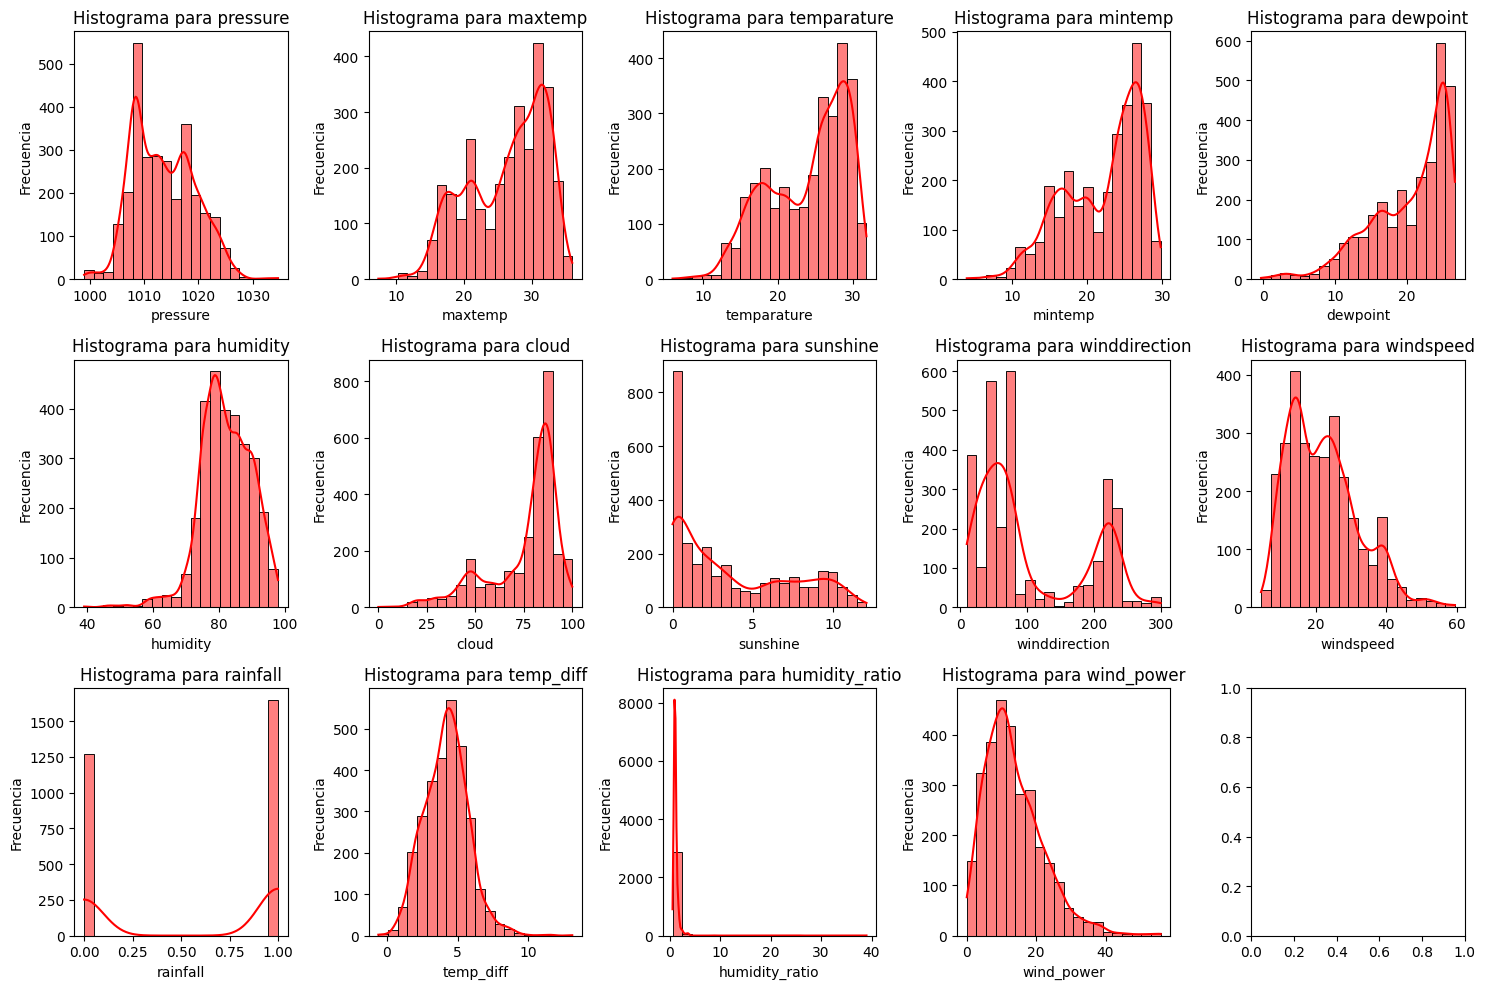

In [719]:
fig, axes = plt.subplots(3,5, figsize=(15, 10))
axes = axes.flatten()
for i, columna in enumerate(df.columns):
    sns.histplot(df[columna], bins=20, color = 'red', ax=axes[i], kde=True)
    axes[i].set_title(f'Histograma para {columna}')
    axes[i].set_xlabel(columna)
    axes[i].set_ylabel('Frecuencia')
plt.tight_layout()
plt.show()

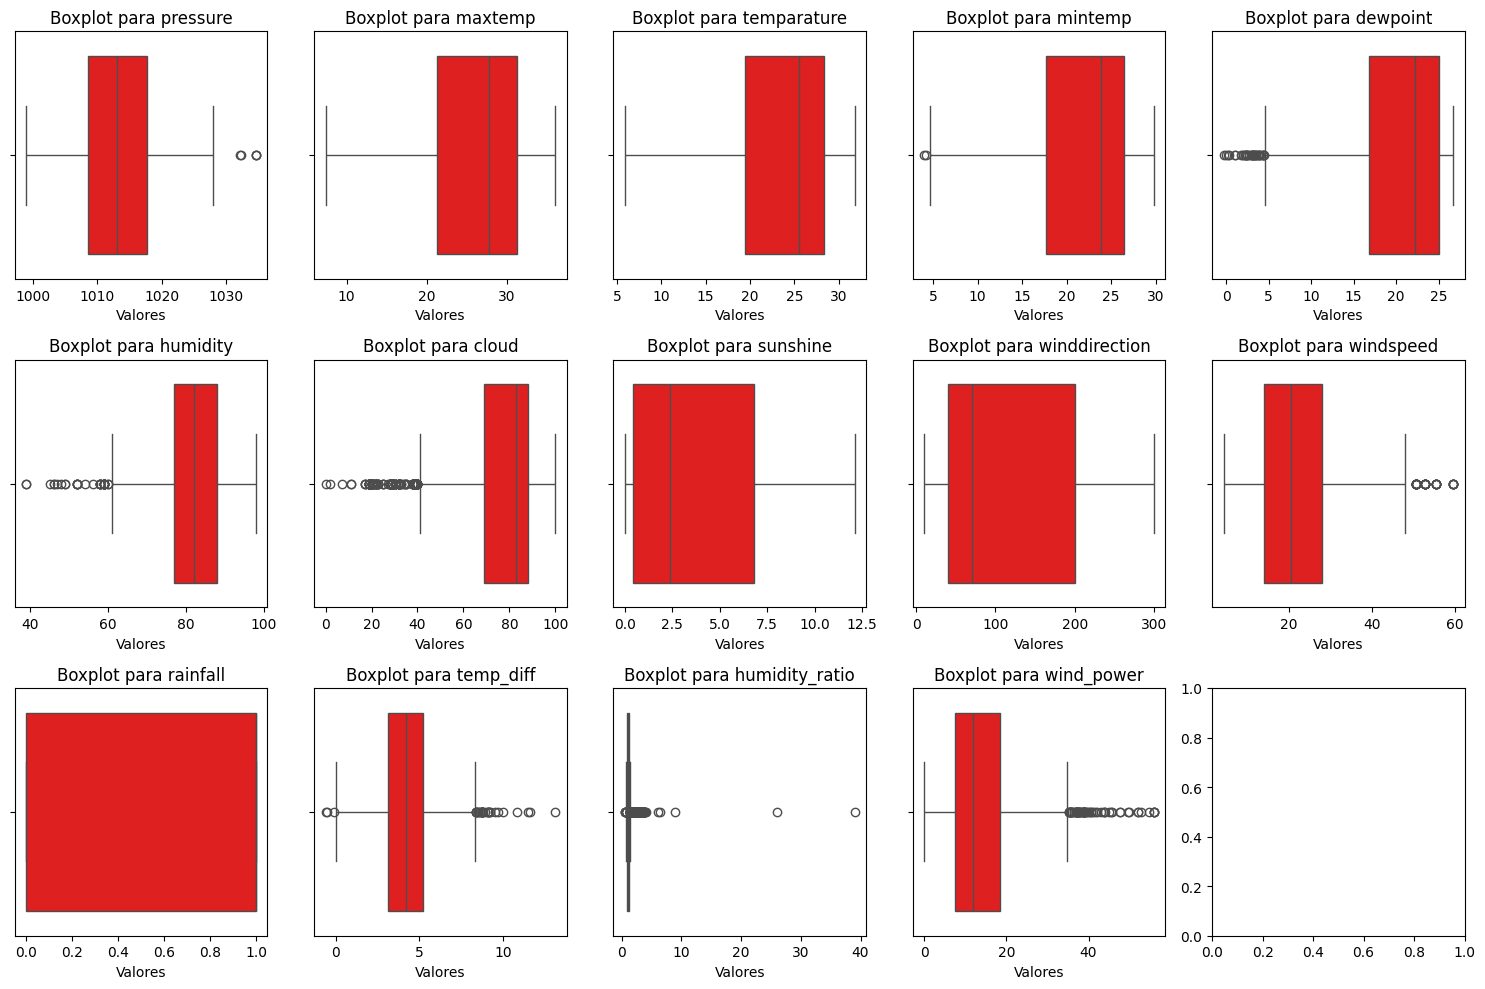

In [720]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i, columna in enumerate(df.columns):
    sns.boxplot(df, x=columna, ax=axes[i], color='red')
    axes[i].set_title(f'Boxplot para {columna}')
    axes[i].set_xlabel('Valores')

plt.tight_layout()
plt.show()

In [721]:
Q1 = df.quantile(0.25)
Q3 = df.quantile(0.75)
IQR = Q3 - Q1

df_filtrado = df[~((df < (Q1 - 1.5 * IQR)) | (df > (Q3 + 1.5 * IQR))).any(axis=1)]


In [722]:
imputer = SimpleImputer(strategy='median')
scaler = MinMaxScaler(feature_range=(0, 1))
transformacion_df= pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
transformacion_df= pd.DataFrame(scaler.fit_transform(transformacion_df), columns=df.columns)
df_testT = pd.DataFrame(imputer.fit_transform(df_test), columns=df_test.columns)
df_testT = pd.DataFrame(scaler.fit_transform(df_testT), columns=df_test.columns)

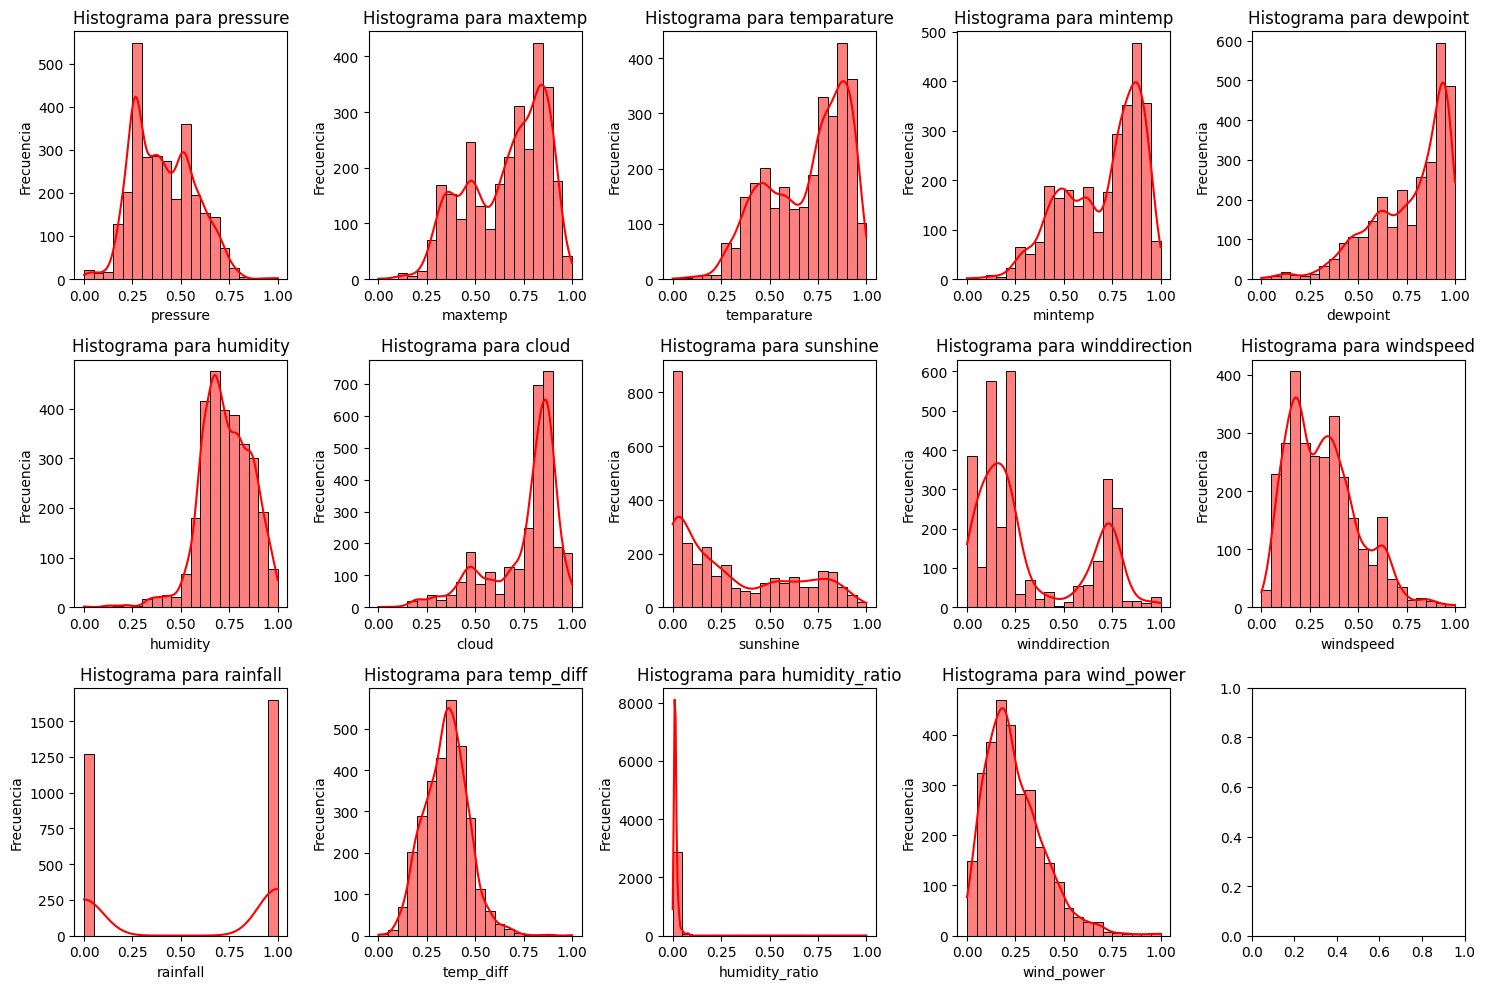

In [723]:
fig, axes = plt.subplots(3, 5, figsize=(15, 10))
axes = axes.flatten()

for i, columna in enumerate(transformacion_df.columns):
    sns.histplot(transformacion_df[columna], bins=20, color='red', ax=axes[i], kde=True)
    axes[i].set_title(f'Histograma para {columna}')
    axes[i].set_xlabel(columna)
    axes[i].set_ylabel('Frecuencia')

plt.tight_layout()
plt.show()

In [724]:
transformacion_df = power_transform(transformacion_df,method='yeo-johnson')
transformacion_df =  pd.DataFrame(transformacion_df, columns=df.columns)

In [725]:
X = transformacion_df.drop(columns='rainfall')
y = df['rainfall'] # Asegurar que `y` tenga el mismo índice


In [726]:
print("X shape:", X.shape)
print("y shape:", y.shape)


X shape: (2920, 13)
y shape: (2920,)


In [727]:
# Separar características (X) y la variable objetivo (y)
# Primera división: 70% Train, 30% Temporal (Validación + Test)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)

# Segunda división: 15% Validación, 15% Test
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

# Ver tamaños de cada conjunto
print(f"Tamaño de Train: {X_train.shape}")
print(f"Tamaño de Validación: {X_val.shape}")
print(f"Tamaño de Test: {X_test.shape}")


Tamaño de Train: (2044, 13)
Tamaño de Validación: (438, 13)
Tamaño de Test: (438, 13)


In [728]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

# Definir el modelo Random Forest con hiperparámetros básicos
rf_model = RandomForestClassifier(
    n_estimators=100,   # Número de árboles
    max_depth=3,       # Profundidad máxima de los árboles
    min_samples_split = 10, # Mínimo de muestras para dividir un nodo
    min_samples_leaf=1,  # Mínimo de muestras por hoja
    random_state=42, 
       
    n_jobs=-1,         # Usa todos los núcleos disponibles
)

# Entrenar el modelo
rf_model.fit(X_train, y_train)

# Hacer predicciones en validación
y_val_probs = rf_model.predict_proba(X_val)[:, 1]
y_test_probs = rf_model.predict_proba(X_test)[:, 1]
# Evaluar con AUC-ROC
auc_val = roc_auc_score(y_val, y_val_probs)
auc_test = roc_auc_score(y_test, y_test_probs)
print(f"AUC-ROC en Validación: {auc_val:.4f}")
print(f"AUC-ROC en Test: {auc_test:.4f}")

AUC-ROC en Validación: 0.7041
AUC-ROC en Test: 0.6898


In [729]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators': [10,30,50,100],
    'max_depth': [1,3,5],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 5, 10]
}

grid_search = GridSearchCV(RandomForestClassifier(random_state=42),
                           param_grid, cv=3, scoring='roc_auc', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("Mejores parámetros:", grid_search.best_params_)


Mejores parámetros: {'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}


 {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mejor AUC-ROC: 0.7097

In [735]:
import xgboost as xgb

model = xgb.XGBClassifier(
    max_depth = 6 ,  # Profundidad del árbol
    learning_rate = 0.05,  # Tasa de aprendizaje
    n_estimators=500,  # Número de árboles
    subsample= 0.8,  # Muestreo de datos
    colsample_bytree= 0.8,
    use_label_encoder=False,
    eval_metric="auc",
    random_state=42
    
)  # Usa XGBRegressor() si es regresión
model.fit(X_train, y_train)

# Obtener probabilidades de predicción
y_probs = model.predict_proba(X_test)[:, 1]  # Solo tomamos la probabilidad de la clase positiva

# Calcular el AUC-ROC
auc_roc = roc_auc_score(y_test, y_probs)
print(f'AUC-ROC Score: {auc_roc:.4f}')



C:\Users\Oscar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\xgboost\core.py:158: UserWarning: [14:51:20] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


AUC-ROC Score: 0.6686


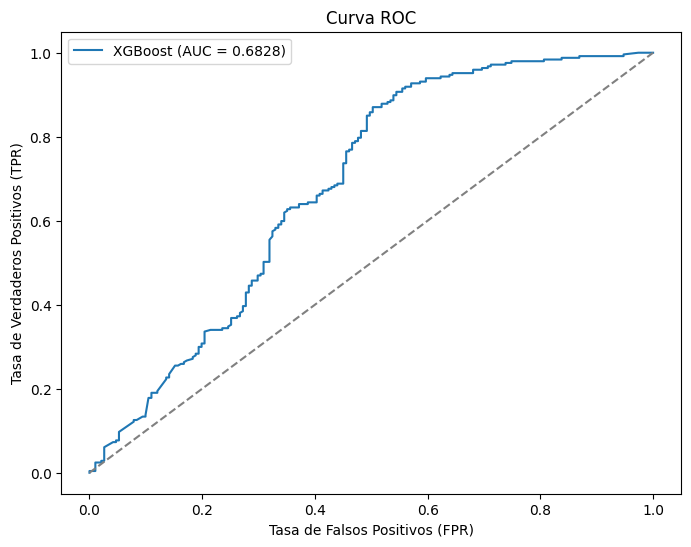

In [731]:
# Calcular la curva ROC
fpr, tpr, _ = roc_curve(y_test, y_probs)

# Graficar
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_roc:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')  # Línea diagonal
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva ROC')
plt.legend()
plt.show()


In [732]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'max_depth': [3, 5, 7],  # Profundidad del árbol
    'learning_rate': [0.01, 0.1, 0.2],  # Tasa de aprendizaje
    'n_estimators': [100, 200, 300],  # Número de árboles
    'subsample': [0.8, 1],  # Muestreo de datos
    'colsample_bytree': [0.8, 1]  # Muestreo de características
}

grid_search = GridSearchCV(
    estimator=xgb.XGBClassifier(),
    param_grid=param_grid,
    scoring='roc_auc',
    cv=5,  # Validación cruzada
    n_jobs=-1
)

grid_search.fit(X_train, y_train)

# Mejor modelo
best_model = grid_search.best_estimator_
print(f"Mejores parámetros: {grid_search.best_params_}")
print(f"Mejor AUC-ROC: {grid_search.best_score_:.4f}")


Mejores parámetros: {'colsample_bytree': 1, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 100, 'subsample': 0.8}
Mejor AUC-ROC: 0.7097


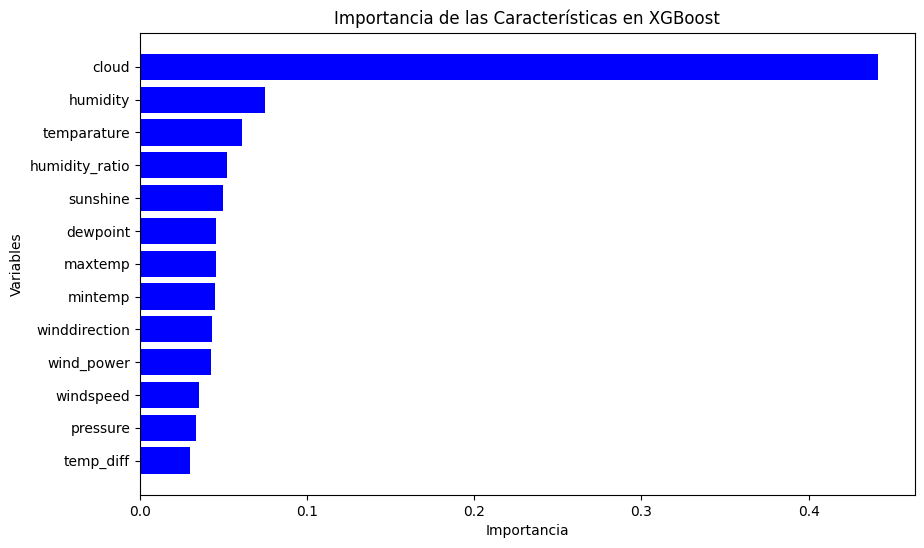

In [733]:
import numpy as np
import matplotlib.pyplot as plt

# Obtener la importancia de características
importances = best_model.feature_importances_

# Ordenar las características por importancia
indices = np.argsort(importances)  # Índices ordenados

plt.figure(figsize=(10, 6))
plt.barh(np.array(X_train.columns)[indices], importances[indices], color='blue')  # Ordenar correctamente
plt.xlabel('Importancia')
plt.ylabel('Variables')
plt.title('Importancia de las Características en XGBoost')
plt.show()


In [734]:
y_pred = rf_model.predict(df_testT)